In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [3]:
barts_hotspots = pd.read_csv("data/barts_hotspots.csv")
barts_to_all = pd.read_csv("data/barts_to_all.csv")
hotspots_to_all = pd.read_csv("data/hotspots_to_all.csv")

In [7]:
locations = {3603 : 'Embarcadero Station',3692 : 'Montgomery BART Station',3760: 'Powell BART Station', 3396: 'Palace of Fine Arts', 3394: 'Fisherman\'s Wharf', 3792: 'Oracle Park'}

distances = {"Embarcadero Station to Oracle Park":1.5,
 "Montgomery BART Station to Oracle Park": 1.4,
 "Powell BART Station to Oracle Park": 1.1,
    "Oracle Park to Embarcadero Station":1.3,
    "Oracle Park to Montgomery BART Station": 1.1,
"Oracle Park to Powell BART Station":1.8}

In [4]:
# Raw data for input and output
df = pd.read_csv("data/raw_data.csv")

In [5]:
df.head(1)

,Date,Origin Movement ID,Origin Display Name,Destination Movement ID,Destination Display Name,Daily Mean Travel Time (Seconds),Daily Range - Lower Bound Travel Time (Seconds),Daily Range - Upper Bound Travel Time (Seconds),AM Mean Travel Time (Seconds),AM Range - Lower Bound Travel Time (Seconds),...,Midday Range - Lower Bound Travel Time (Seconds),Midday Range - Upper Bound Travel Time (Seconds),Evening Mean Travel Time (Seconds),Evening Range - Lower Bound Travel Time (Seconds),Evening Range - Upper Bound Travel Time (Seconds),Early Morning Mean Travel Time (Seconds),Early Morning Range - Lower Bound Travel Time (Seconds),Early Morning Range - Upper Bound Travel Time (Seconds),DayOfWeek,Month
0,2019-04-18,3792,"Oracle Park, 24 Willie Mays Plaza, San Francis...",3603,"Embarcadero, San Francisco, CA",512.0,371.0,705.0,648.0,461.0,...,398.0,702.0,442.0,321.0,608.0,363.0,297.0,443.0,3,4


In [113]:
df["Date"].max()

'2019-06-30'

In [114]:
df["Date"].min()

'2019-01-01'

# Preprocess Data
- [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

## What data has

- Input: Origin ID, Destination ID, DayOfWeek, Month
- Output: Daily Mean Travel Time

## Split
- train 80%
- val 10%
- val 10%

In [97]:
def split_data(data):
    train_df, test_df = train_test_split(data, test_size=0.1)
    train_df, val_df = train_test_split(train_df, test_size=(1/9))
    return {"train": train_df, "val":val_df, "test":test_df}

In [98]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

data_dict = {}

# Data that encodes all the time info
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df[["Origin Movement ID", "Destination Movement ID", "DayOfWeek", "Month"]])
X = enc.transform(df[["Origin Movement ID", "Destination Movement ID", "DayOfWeek", "Month"]])
y = df["Daily Mean Travel Time (Seconds)"]
y = np.transpose(np.array(y, ndmin=2))
data = np.append(X.toarray(),y,axis=1)
data_dict["encoded"] = split_data(data)

# Data that leaves time as numeric
X = preprocessing.scale(df[["DayOfWeek", "Month"]].to_numpy())
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df[["Origin Movement ID", "Destination Movement ID"]])
X = np.append(X, enc.transform(df[["Origin Movement ID", "Destination Movement ID"]]).toarray(), axis=1)
y = df["Daily Mean Travel Time (Seconds)"]
y = np.transpose(np.array(y, ndmin=2))
data = np.append(X, y,axis=1)
data_dict["numeric"] = split_data(data)

# [Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

In [103]:
train_df, val_df = data_dict["encoded"]["train"], data_dict["encoded"]["val"]

reg = LinearRegression().fit(train_df[:,:-1], train_df[:,-1])
reg.score(val_df[:,:-1], val_df[:,-1])

0.7883588463910652

# [SVM Regression (SVR)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)

In [104]:
from sklearn.svm import SVR
train_df, val_df = data_dict["encoded"]["train"], data_dict["encoded"]["val"]
svr = SVR(C=1.0, kernel="linear")
svr.fit(train_df[:,:-1], train_df[:,-1])

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [105]:
svr.score(val_df[:,:-1], val_df[:,-1])

0.48328206458326406

# [Hyperparameter-tuning](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)

In [106]:
from sklearn.model_selection import GridSearchCV

svr = SVR(kernel="linear")
parameters = {'C':[0.01 * (2** i)  for i in range(20)]}
clf = GridSearchCV(svr, parameters)
clf.fit(train_df[:,:-1], train_df[:,-1])

/Users/yabutamidori/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated',
                           kernel='linear', max_iter=-1, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28,
                               2.56, 5.12, 10.24, 20.48, 40.96, 81.92, 163.84,
                               327.68, 655.36, 1310.72, 2621.44, 5242.88]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

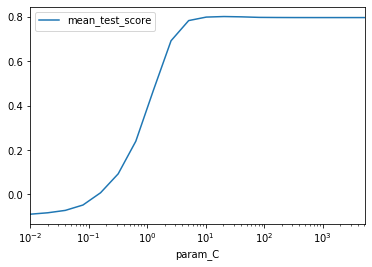

In [111]:
ax = pd.DataFrame(clf.cv_results_)[["param_C", "mean_test_score"]].set_index("param_C").plot()
ax.set_xscale('log')